## Constructing Posterior 

Observed data $Y$ and the model output $G(\mu)$ are three-dimensional, corresponding to the $x, y, z$ coordinates. That's why you need to calculate **log likelihood** for each component individually and combine them to get the total **log likelihood**:

\begin{equation}
\log \nu(Y | \mu) = -\frac{N}{2}\log ((2 \pi)^3 \det ( \Sigma)) - \frac {1}{2 } \sum_{i=1}^{N} (Y_i - G(\mu))^{T} \det ( \Sigma)^{-1}(Y_i - G(\mu))
\end{equation}

where $N$ is the number of observations, $Y_i= (Y_{x,i}, Y_{y,i}, Y_{z,i})^{T}$ and $G(\mu)=(G_x(\mu)_i, G_y(\mu)_i, G_z(\mu)_i)^{T} $ are the observed data vector and the model output at time $i$, respectively. If we assume that the noise is inpedendent across $x,y,z$ then the covariance matrix $\Sigma= \sigma^2_{noise} \mathbf I$.

Now we can generate datum $Y$ by calling UM-Bridge model and then construct **log posterior**.

In [1]:
import umbridge
import numpy as np

model = umbridge.HTTPModel("http://localhost:4242", "forward")
result = np.array(model([[0.012149623731558415]]))
data_x = result[0]
data_y = result[1]
data_z = result[2]

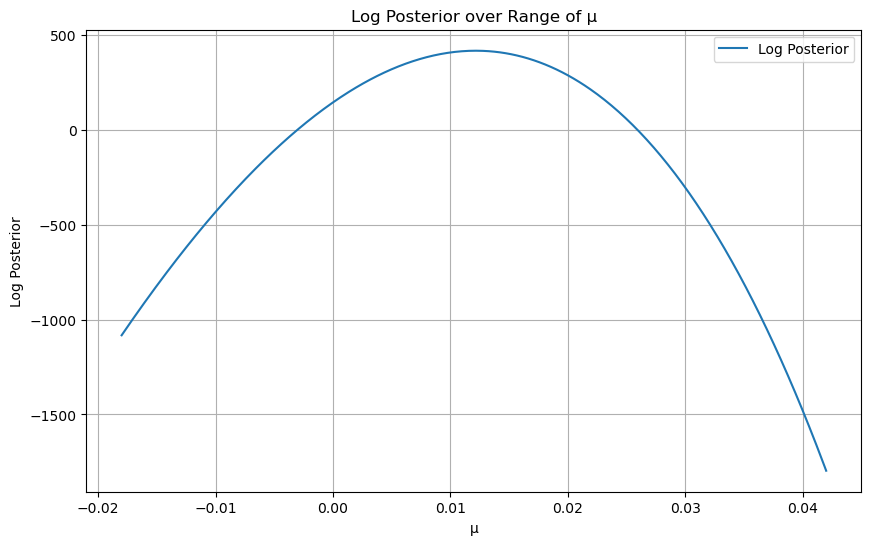

In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from mpl_toolkits.mplot3d import axes3d
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import numpy
from scipy.linalg import block_diag
from scipy import linalg

# parameters 
var_prior = 0.01**2
mean_prior = 0.012
var_noise = 0.01
mean_noise = 0

# defining log-prior distribution  
def g(mu):
    log_prior_pdf = -0.5 * np.log(2 * np.pi* var_prior) - 0.5*(((mu - mean_prior)**2)/(var_prior))
    return log_prior_pdf


# add noise to the observed data
Yx_obs = (data_x + np.random.normal(mean_noise, var_noise, data_x.shape)).flatten()
Yy_obs = (data_y + np.random.normal(mean_noise, var_noise, data_y.shape)).flatten()
Yz_obs = (data_z + np.random.normal(mean_noise, var_noise, data_z.shape)).flatten()
N = len(Yx_obs)

# defining likelihood function
def f(mu):
    model_result = np.array(model([[mu]])) #during MCMC candidate values for µ will be proposed and for each µ, the forward model will be solved
    Yx_model = model_result[0].flatten()
    Yy_model = model_result[1].flatten()
    Yz_model = model_result[2].flatten()

    cov_matrix = var_noise * np.identity(N)
    inverse_cov_matrix = np.linalg.inv(cov_matrix)
    
    diff_x = Yx_obs - Yx_model
    diff_y = Yy_obs - Yy_model
    diff_z = Yz_obs - Yz_model
    
    log_likelihood_pdf_x = -0.5*N*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(cov_matrix)) - 0.5* (diff_x.T @ (inverse_cov_matrix) @ diff_x)
    log_likelihood_pdf_y = -0.5*N*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(cov_matrix)) - 0.5* (diff_y.T @ (inverse_cov_matrix) @ diff_y)
    log_likelihood_pdf_z = -0.5*N*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(cov_matrix)) - 0.5* (diff_z.T @ (inverse_cov_matrix) @ diff_z)

    log_likelihood_pdf = log_likelihood_pdf_x + log_likelihood_pdf_y + log_likelihood_pdf_z
    return log_likelihood_pdf


# constructing posterior 
def p(mu):
    log_post_pdf = g(mu) + f(mu) 
    return log_post_pdf


# defining the range of µ values to evaluate the posterior
mu_values = np.linspace(-0.018, 0.042, 500)

# computing the log posterior for each µ value
log_posteriors = np.array([p(mu) for mu in mu_values])

# plotting the log posterior
plt.figure(figsize=(10, 6))
plt.plot(mu_values, log_posteriors, label='Log Posterior')
plt.xlabel('µ')
plt.ylabel('Log Posterior')
plt.title('Log Posterior over Range of µ')
plt.legend()
plt.grid(True)
plt.show()

## Markov Chain Monte Carlo (MCMC)

Given that direct sampling from the posterior distribution is not possible, we employ the Markov Chain Monte Carlo (MCMC) method. A widely recognized algorithm for MCMC is Metropolis Hastings algorithm.

For this algorithm, we need to define proposal distribution which generates new candidate values $\mu'$ based on the current state. In our case, suppose that initial state is $\mu_0 = 0.012$ and we are using Gaussian proposal distribution $q(\mu_j, \ \mu')$ with mean $\mu_j$ and variance $\sigma_{proposal}^2 = 0.01$. Thereafter, accaptance probabilty can be computed. 

**Remark.** We are working with the logarithm of likelihood and the prior. Therefore, when we calculate the acceptance probability, we need to consider the log scale transformation.

Iteration  Proposed mu               Accepted   log_u      log_alpha 
0          0.016967141530112327      True       -0.31198   -0.12336  
1          0.015584498518400481      True       -0.51306   0.00000   
2          0.013242964771167121      True       -2.84587   0.00000   
3          0.010901595201675315      True       -0.14367   0.00000   
4          0.02669372335674923       True       -3.88322   -1.07350  
5          0.03436807064827832       False      -0.03055   -1.42213  
6          0.02199897949739971       True       -1.70471   0.00000   
7          0.027424579933259356      True       -1.69606   -0.68969  
8          0.029844202648919696      True       -0.83946   -0.40249  
9          0.010711400202341717      True       -1.23364   0.00000   


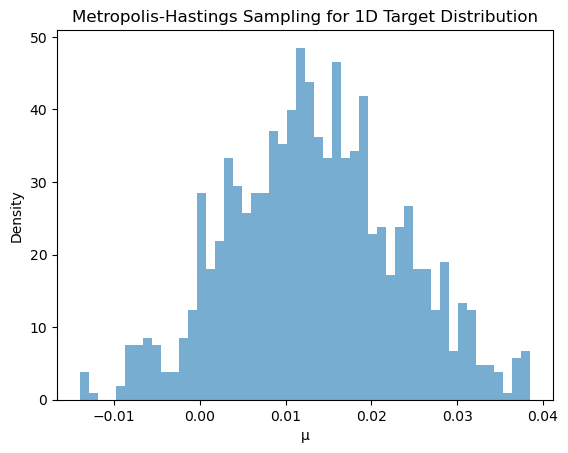

In [17]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import arviz as az

np.random.seed(42)

# Define the proposal distribution
def proposal_distribution(mu, var=0.01):
    return np.random.normal(mu, var)

# Metropolis-Hastings algorithm
def metropolis_hastings(initial_state, num_samples, p, proposal_distribution, var=0.01):
    samples = []  # List to store the samples
    mu = initial_state  # Start from the initial state
    acceptances = []

    for j in range(num_samples):
        # Given the current state x_j = x, draw a realization x' from Q(x, .)
        mu_prime = proposal_distribution(mu, var)
        
        # Compute the acceptance probability α(x, x')
        log_alpha = min(0, p(mu_prime) - p(mu))
        
        # Draw an independent sample u_j+1 ~ uniform[0, 1]
        log_u = np.log(np.random.uniform(0, 1))
        
        if log_u <= log_alpha:
            mu = mu_prime  # Accept the new state
            accepted = True
        else:
            accepted = False

        samples.append(mu)  # Store the current state (whether accepted or not)

        # Store acceptance info for the first 10 iterations
        if j < 10:
            acceptances.append((mu_prime, accepted, log_u, log_alpha))

    return np.array(samples), acceptances

# Parameters
initial_state = 0.012
num_samples = 1000

# Run Metropolis-Hastings algorithm
samples, acceptances = metropolis_hastings(initial_state, num_samples, p, proposal_distribution)

# Print acceptance info for the first 10 iterations
print(f"{'Iteration':<10} {'Proposed mu':<25} {'Accepted':<10} {'log_u':<10} {'log_alpha':<10}")
for i, (mu_prime, accepted, log_u, log_alpha) in enumerate(acceptances):
    print(f"{i:<10} {str(mu_prime):<25} {str(accepted):<10} {log_u:<10.5f} {log_alpha:<10.5f}")

# Plot samples
plt.hist(samples, bins=50, density=True, alpha=0.6, label='Samples')
plt.title('Metropolis-Hastings Sampling for 1D Target Distribution')
plt.xlabel('µ')
plt.ylabel('Density')
plt.show()

As in `MCMC Example`, we can use `ArviZ` package to obtain the following graphs. 

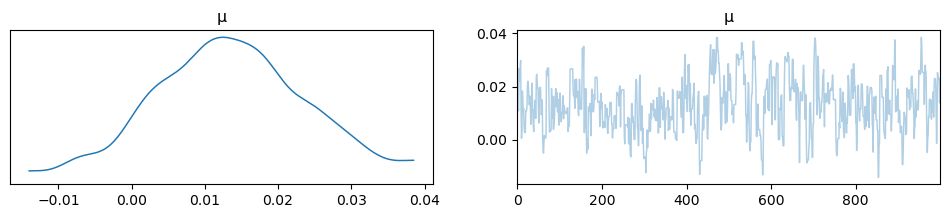

In [18]:
# Use ArviZ to create an InferenceData object
import arviz as az
az_data = az.from_dict(posterior={'µ': samples})

# Plot the results using ArviZ
az.plot_trace(az_data)
plt.show()

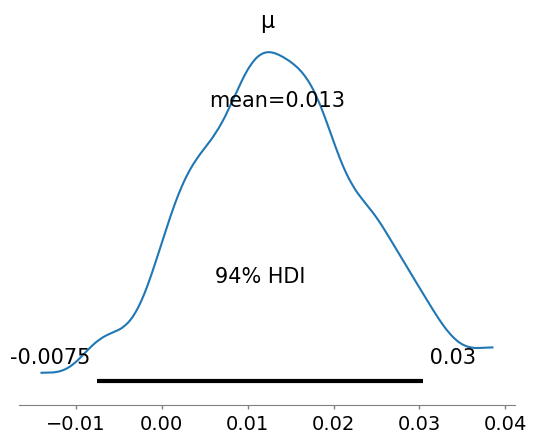

In [19]:
# Plot the posterior density using ArviZ
az.plot_posterior(az_data)
plt.show()

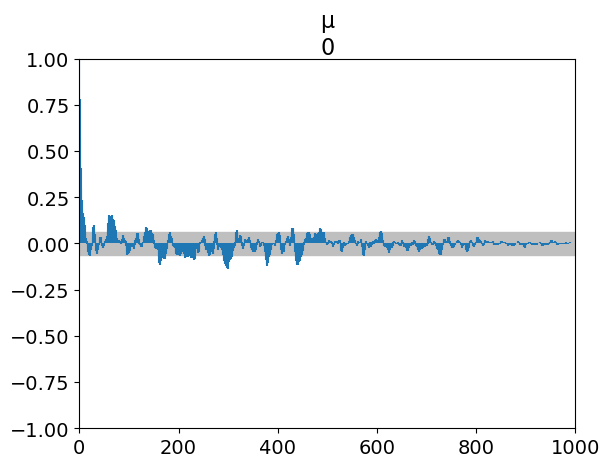

In [20]:
# Plot the autocorrelation of the samples
az.plot_autocorr(az_data, max_lag=1000)#
plt.show()